In [ ]:
!pip install tensorflow==2.12
!pip install keras==2.12
!pip install music21
!pip install numpy

### Load

In [1]:
import os
import numpy as np
from music21 import converter, pitch, interval, instrument, note, stream
from matplotlib import pyplot as plt

from xen.visualise import plotPart, plotSparseNoteSequence
from xen.data.songdata import SongDataSet

data_dir = "../../../ml_training/music/mutopia_guitar/"

dataset = SongDataSet()
dataset.loadMidiDir(data_dir)

print(f'Loaded {len(dataset.songs)} Songs') 


Loading 385 files
Loaded 385 Songs


### Filter

In [2]:
dataset.filterTimeSig('4/4')
print(f'{len(dataset.songs)} Songs') 

95 Songs


###  Encode

In [3]:
from xen.data.codecs import SparseNoteSequenceCodec, FlatNoteSequenceCodec

ticksPerQuarter = 4   # 4 = 16th notes, to allow triplets would need to be 12 = 48 per measure
measuresPerSequence = 1

codec = FlatNoteSequenceCodec(ticksPerQuarter, measuresPerSequence, '4/4')
codec.initEncode(dataset)

print(dataset.sequences.shape)

Ignored 20 sequences from ../../../ml_training/music/mutopia_guitar/Matiegka3.mid
Ignored 2 sequences from ../../../ml_training/music/mutopia_guitar/capricho-arabe.mid
Ignored 24 sequences from ../../../ml_training/music/mutopia_guitar/carcassi-op60-03.mid
Ignored 3 sequences from ../../../ml_training/music/mutopia_guitar/horetzky29.mid
Ignored 84 sequences from ../../../ml_training/music/mutopia_guitar/sorf-op6n11.mid
Ignored 42 sequences from ../../../ml_training/music/mutopia_guitar/sorf-op6n07.mid
Ignored 69 sequences from ../../../ml_training/music/mutopia_guitar/claro-de-luna.mid
Ignored 70 sequences from ../../../ml_training/music/mutopia_guitar/moonlight-guitar-duo.mid
Ignored 1 sequences from ../../../ml_training/music/mutopia_guitar/bwv-1006a_3g.mid
Ignored 1 sequences from ../../../ml_training/music/mutopia_guitar/guitar-skole-no-09.mid
Ignored 2 sequences from ../../../ml_training/music/mutopia_guitar/Sor_Etude_Opus35_14.mid
Ignored 1 sequences from ../../../ml_training/mus

In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from xen.models.autoencoder import VariationalAutoEncoder

autoencoder = VariationalAutoEncoder(dataset.sequences.shape[1], internalDim=64, latentDim=8)
autoencoder.compile(optimizer=Adam(learning_rate=0.005))

2023-05-01 12:06:42.637824: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 2048)]       0           []                               
                                                                                                  
 encoder_internal (Dense)       (None, 512)          1049088     ['encoder_input[0][0]']          
                                                                                                  
 encoder_mean (Dense)           (None, 32)           16416       ['encoder_internal[0][0]']       
                                                                                                  
 encoder_logvar (Dense)         (None, 32)           16416       ['encoder_internal[0][0]']       
                                                                                            

### Train

In [5]:


autoencoder.train(dataset.sequences, batchSize = 32, epochs = 500)


Train on 3159 samples
Epoch 1/500


2023-05-01 12:06:49.510366: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/dense/bias/m/Assign' id:504 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/bias/m, training/Adam/dense/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


3159/3159 [==============================] - 2s 710us/sample - loss: 49.7447
Epoch 2/500
3159/3159 [==============================] - 1s 467us/sample - loss: 1.0995
Epoch 3/500
3159/3159 [==============================] - 2s 542us/sample - loss: 0.3750
Epoch 4/500
 928/3159 [=======>......................] - ETA: 1s - loss: 0.2262

KeyboardInterrupt: 

In [6]:


def countMatches(indata, outdata):
    matches = 0
    for i in range(0, len(indata)):
        insequence = indata[i]
        outsequence = outdata[i]
        match = True
        for j in range(len(insequence)):
            if ((insequence[j] >= 0.5 and outsequence[j] < 0.5) or (insequence[j] < 0.5 and outsequence[j] >= 0.5)):
                match = False
                # print(i)
        if (match):
            matches = matches + 1
    return matches
    

output = autoencoder.predict(dataset.sequences)

matches = countMatches(dataset.sequences, output)
print(f'{matches/len(dataset.sequences)*100}% recall')



/Users/rob/anaconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-01 12:01:19.022551: W tensorflow/c/c_api.cc:300] Operation '{name:'decoder/decoder_output/Sigmoid' id:154 op device:{requested: '', assigned: ''} def:{{{node decoder/decoder_output/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decoder/decoder_output/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


0.0% recall


### Visualise Latent Space

2023-05-01 12:01:37.032399: W tensorflow/c/c_api.cc:300] Operation '{name:'encoder_mean/BiasAdd' id:49 op device:{requested: '', assigned: ''} def:{{{node encoder_mean/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](encoder_mean/MatMul, encoder_mean/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


[-3.836353e-06 -3.836353e-06 -3.836353e-06 ... -3.836353e-06 -3.836353e-06
 -3.836353e-06]


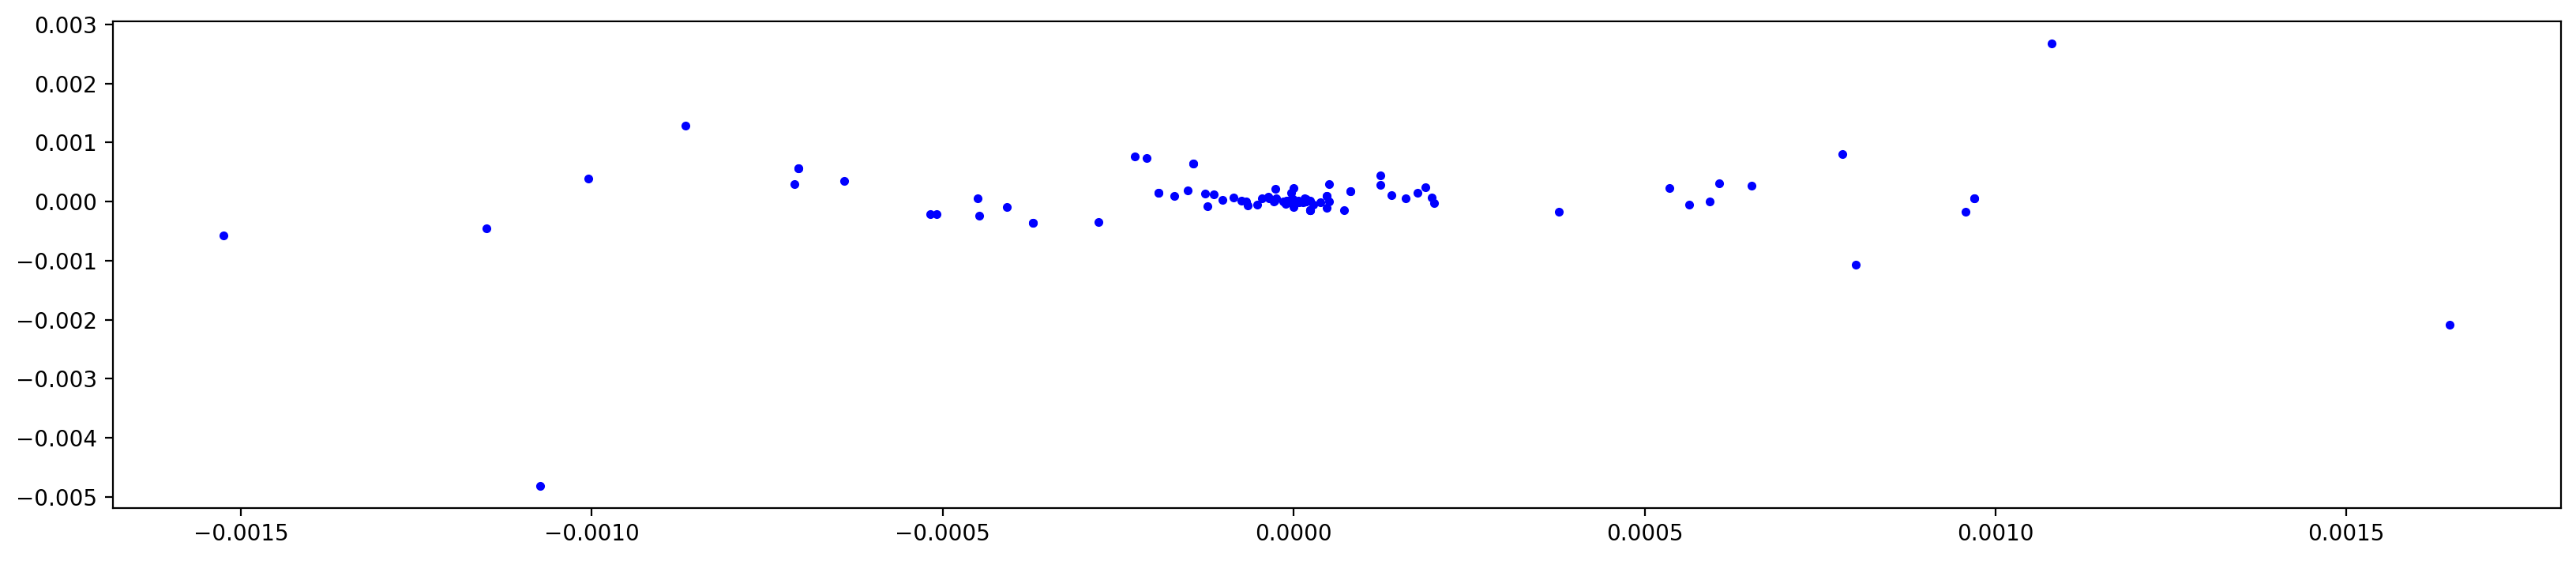

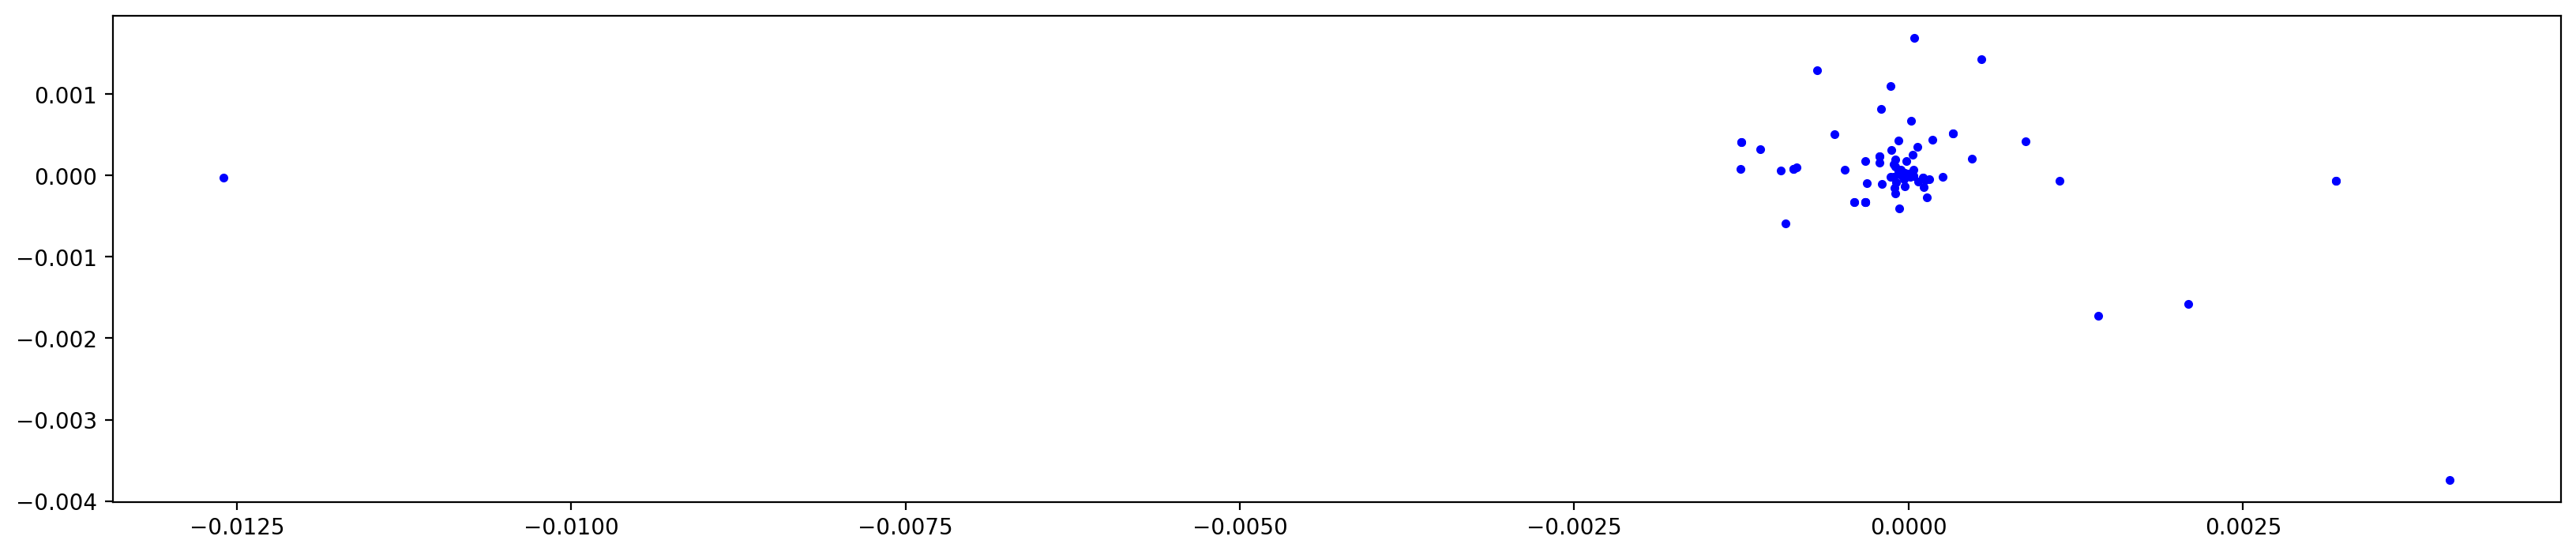

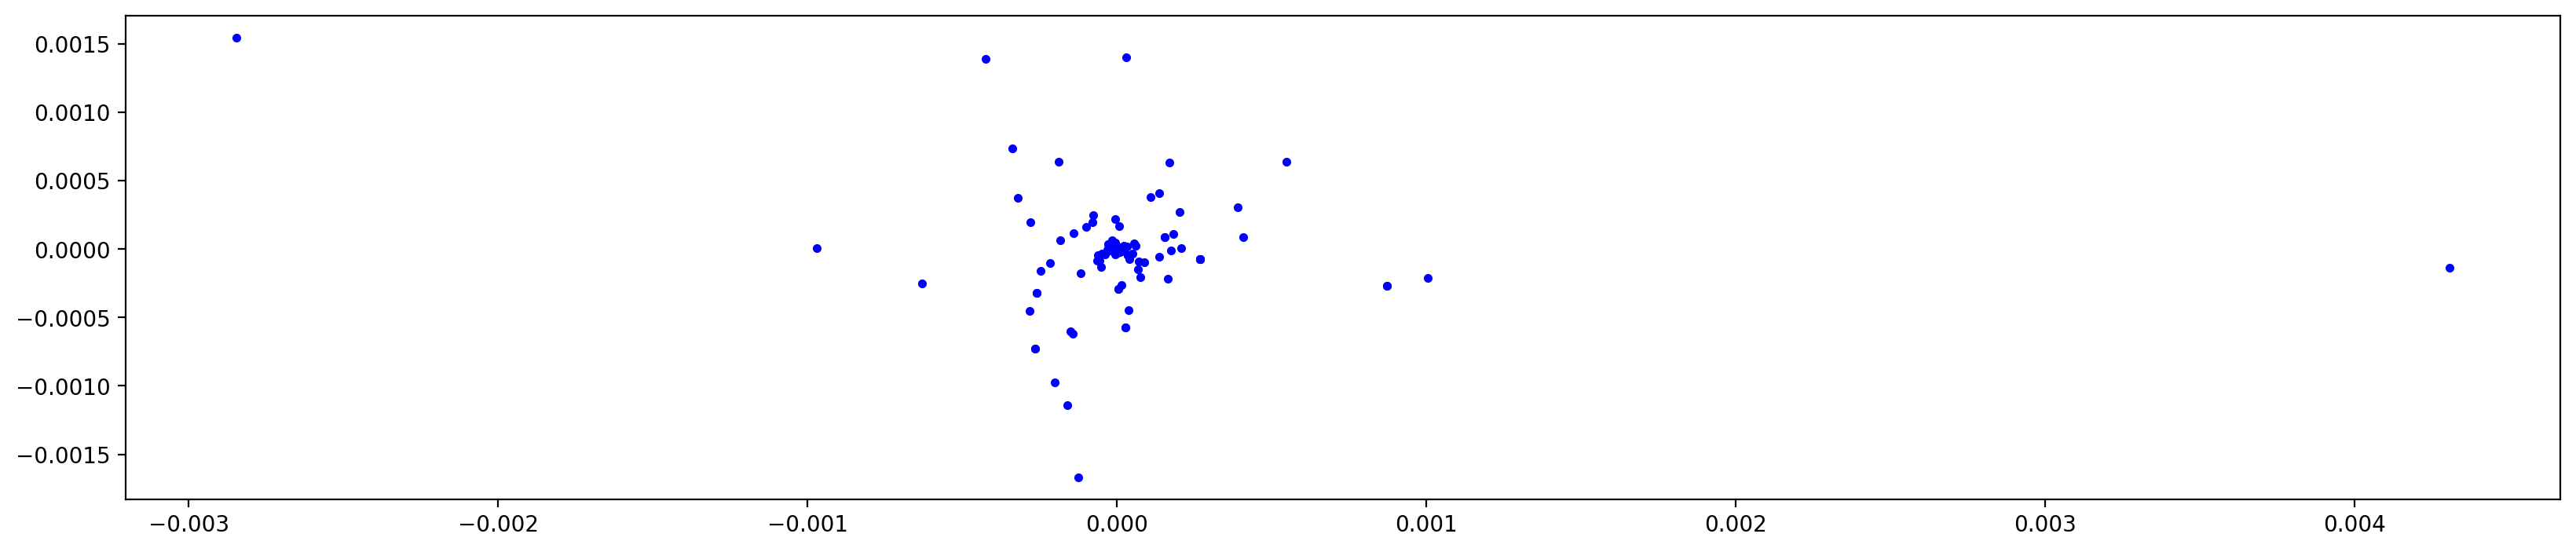

In [7]:
latentdata = autoencoder.encode(dataset.sequences)
sampling = np.array(latentdata[0])
print(sampling[:,0])

plt.figure(figsize=(20, 4))
plt.scatter(sampling[:,0], sampling[:,1], color='b', marker='.')
plt.show()

plt.figure(figsize=(20, 4))
plt.scatter(sampling[:,2], sampling[:,3], color='b', marker='.')
plt.show()

plt.figure(figsize=(20, 4))
plt.scatter(sampling[:,4], sampling[:,5], color='b', marker='.')
plt.show()

(3159, 2048)


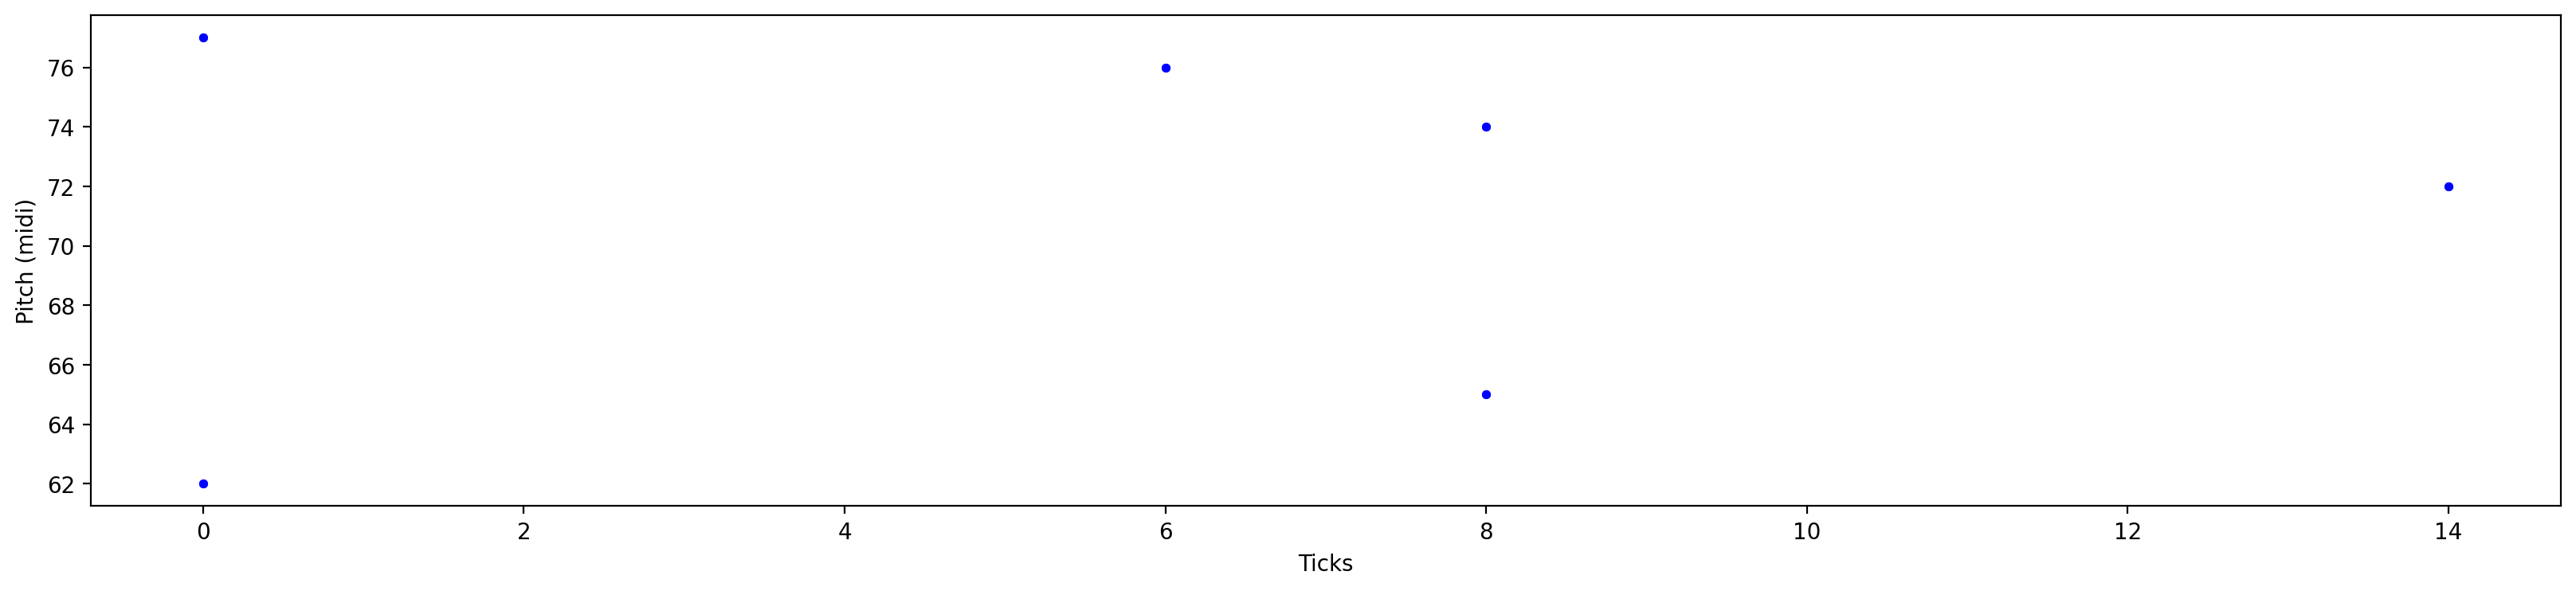

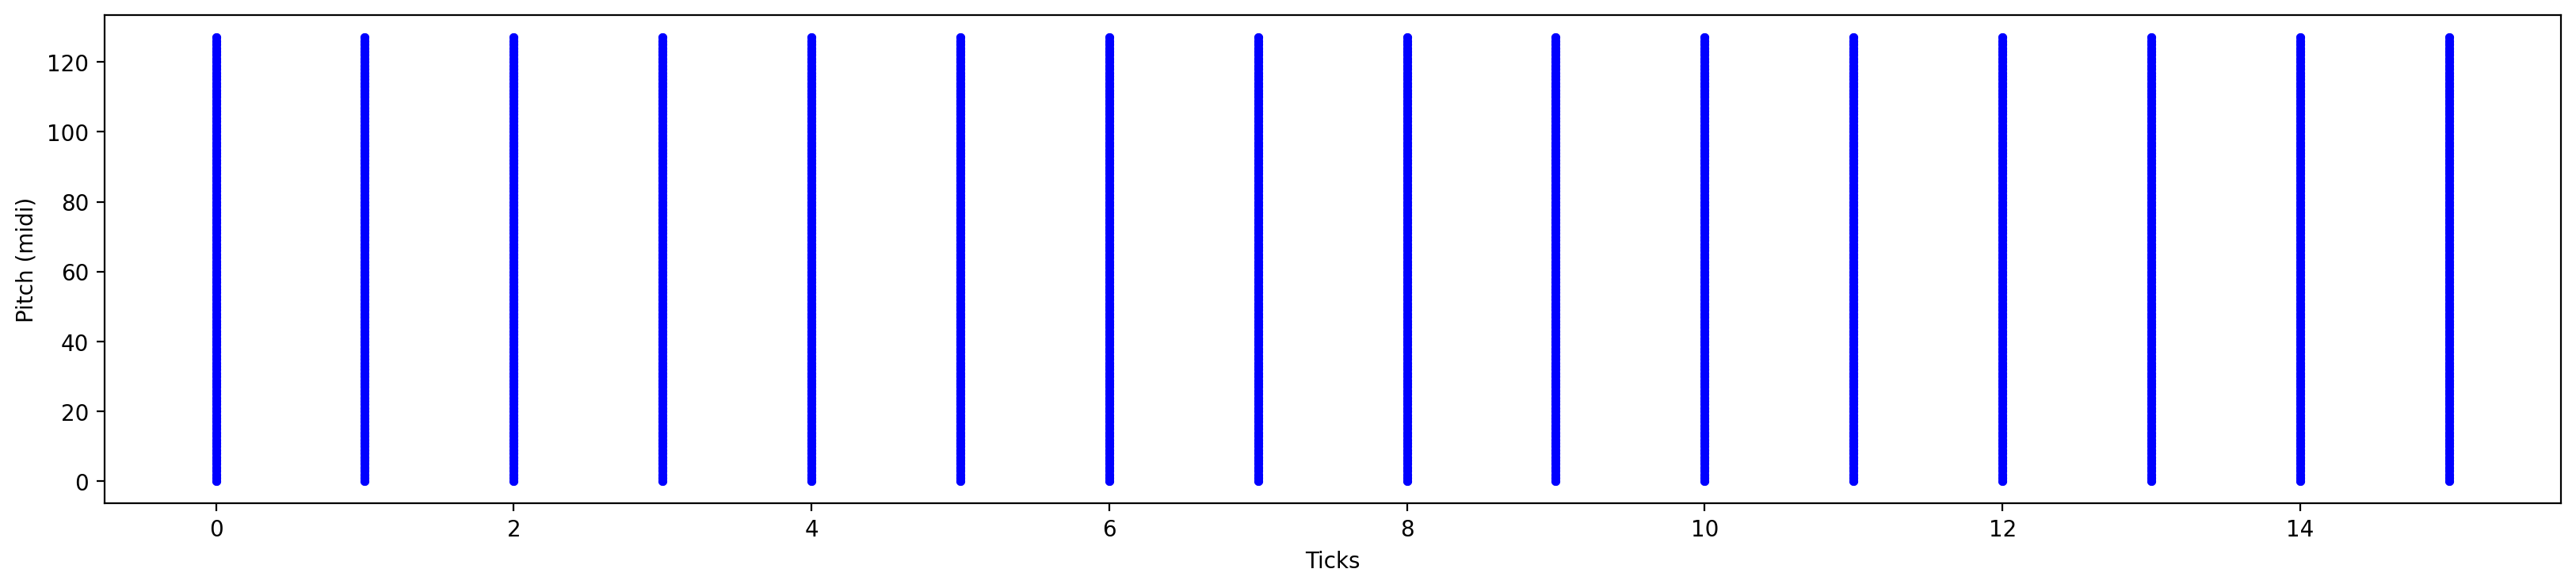

[1.        1.        1.        ... 0.9999998 1.        1.       ]


In [8]:
index = 2

print(output.shape)


plotSparseNoteSequence(codec.decode(dataset.sequences[index:index+1])[0])
plotSparseNoteSequence(codec.decode(output[index:index+1])[0], threshold = 0.5)


print(np.amax(output, axis = 1))